# This is a collage maker software

Main function is to scale a normal photo to a given shape, the conditions below must be satisfied:

- retain all information
- pad empty space with blurred image
- padding has to be at top and bottom, not left or right

For example, if a raw image has shape (1200, 900), and the shape of collage is set at (1000, 1800). Then the raw image will be rescaled to (1000, 750), and paddings will be 1050 pixels in total, 525 top and 525 bottom.

Alternatively, I can skip the rescaling step and directly add paddings to the orginal image. Then output the images using the same shape. <font color="red"> Try this first </font>

## 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
import pylab
import myImageLib as mil
import os

## 2. Processing

- 2.1 padding
- 2.2 trimming

### 2.0 Resize original image

Sometimes, the original image is much larger than the output. Such high quality, however, will not retain in the final collage. Yet, it can slow down the calculation significantly. Therefore, we start the process by resizing the original image to an appropriate size. 

For example:

    shape_orig = (3000, 4000)
    shape_set = (1950, 1000)
    
First, note that aspect ratio $a_{orig} \le a_{set}$, so that we can resize the width first and resize height accordingly. Conversely, when $a_{orig} > a_{set}$, we resize height first and process width accordingly.

In [76]:
def resize_image(original_image, shape_set):
    """
    Args:
    shape_orig -- shape of original image, a tuple of two integers
    shape_set -- shape of preset, a tuple of two integers
    
    Returns:
    resized -- the resized image    
    """
    
    h0, w0 = original_image.shape[0:2]
    h1, w1 = shape_set
    
    a_orig = h0 / w0
    a_set = h1 / w1
    
    if a_orig <= a_set:
        w0p = w1
        h0p = int(w0p * a_orig)
    else:
        h0p = h1
        w0p = int(h0p / a_orig)
    
    resized = cv2.resize(original_image, (w0p, h0p))    
    
    return resized

Wall time: 42 ms


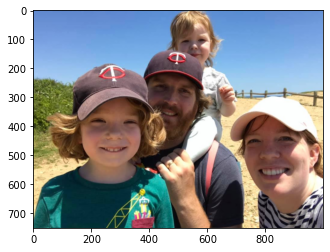

In [77]:
%%time
# test resize_image(original_image, shape_set)
original_image = io.imread(r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\Kyle\kyle_family_Long Island.jpg')
shape_set = (1950, 1000)
resized = resize_image(original_image, shape_set)
plt.imshow(resized)

### 2.1 Padding

**Compute padding size**

Padding aims to convert the aspect ratio (h/w) of original images to the given aspect ratio. In the majority of real cases, $a_{orig} \le a_{set}$. Very rarely, we have $a_{orig} > a_{set}$. If this happens, we crop the center columns of the raw image and trim off both sides. 

In [78]:
def compute_padding_size(shape_orig, shape_set):
    """
    Args:
    shape_orig -- shape of original image, a tuple of two integers
    shape_set -- shape of preset, a tuple of two integers
    
    Returns:
    padding_size -- padding size on one side. Positive size means adding padding at top and bottom. Negative size means trimming left and right.
    """
    
    h0, w0 = shape_orig
    h1, w1 = shape_set
    
    a_orig = h0 / w0
    a_set = h1 / w1
    
    if a_orig <= a_set:
        padding_size = int((w0 * a_set - h0) / 2)
    else:
        padding_size = int((w1 - h0 / a_set) / 2)
    
    return padding_size

In [79]:
# test compute_padding_size(shape_orig, shape_set)
shape_orig = (1200, 900)
shape_set = (1800, 1000)
padding_size = compute_padding_size(shape_orig, shape_set)
print('padding_size: ' + str(padding_size))

padding_size: 210


**Generate padding**

If padding_size is positive, we need to generate a padding based on the original image. If padding_size is smaller than the height of original image, we crop part of the original image, blur it, and then use it as padding. Specifically, for the top padding, we crop the top part; for the bottom padding, we crop the bottom part.

Very rarely, the padding size is even bigger than the height of the orginal image. In this case, we repeat the raw image several times starting from the top and bottom boundary, until a space smaller than the original image is left. Then we use the method in the first case to generate the padding. 

In [80]:
def generate_padding(padding_size, original_image):
    """
    Args:
    padding_size -- the size (height) of padding, returned by compute_padding_size()
    original_image -- original_image
    
    Returns:
    padding_top -- top part of the padding
    padding_bottom -- bottom part of the padding
    """
    
    assert(padding_size > 0)
    
    h, w, c = original_image.shape
    
    # initialize paddings
    padding_top = np.zeros((padding_size, w, c))
    padding_bottom = np.zeros((padding_size, w, c))
    
    if padding_size <= h:
        padding_top = original_image[0: padding_size, :, :]
        padding_bottom = original_image[h-padding_size: h, :, :]
    else:
        count = 0
        while padding_size - count*h > h:
            padding_top[count*h: (count+1)*h, :, :] = original_image
            padding_bottom[padding_size-(count+1)*h: padding_size-count*h, :, :] = original_image
            count += 1
        padding_top[count*h: padding_size, :, :] = original_image[0: padding_size-count*h, :, :]
        padding_bottom[0: padding_size-count*h, :, :] = original_image[(count+1)*h-padding_size: h, :, :]
    
    return padding_top, padding_bottom

In [5]:
# test generate_padding(padding_size, original_image)
original_image = io.imread(r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\Kyle\kyle_family_Long Island.jpg')
padding_size = 210
t, b = generate_padding(padding_size, original_image)

<font color='red'> Since generate_padding does not work well, I switch to np.pad with mode 'reflect'</font>

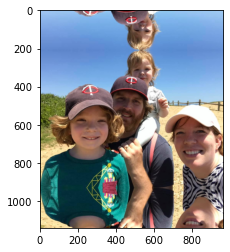

In [81]:
original_image = io.imread(r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\Kyle\kyle_family_Long Island.jpg')
padding_size = 210
padded = np.pad(original_image, ((padding_size, padding_size), (0, 0), (0, 0)), mode='reflect')
plt.imshow(padded)

**Blur the paddings**

Now we have the padded image. We want to emphasize the original image, so all the paddings should be blurred. Here, we implement the function ```blur_paddings()```.

In [111]:
def blur_padding(padded_image, padding_size, padding_sharpness=5, dark_factor=1.2):
    """
    Args:
    padded_image -- the padded image returned by np.pad()
    padding_size -- the size (height) of padding, returned by compute_padding_size()
    padding_sharpness -- how clear the padding parts are, larger value means sharper padding
    dark_factor -- darken the padding parts, 1 is original 
    
    Returns:
    blurred -- padded image with padding part blurred
    
    Note:
    I implement this function in a way not very intuitive. First, I save an instance of the raw image. Then I blur the whole image. Finally, I replace the center part of the blurred image with the saved raw image.
    This method is not computationally efficient as well since it waste some calculation on blurring the raw image. 
    """
    hp, wp, cp = padded_image.shape
    blur_size = int(wp / padding_sharpness)
    
    orginal_image = padded_image[padding_size: hp-padding_size, :, :]
    
    blurred = cv2.blur(padded_image, (blur_size, blur_size))
    
    blurred = np.floor(np.array(blurred) / dark_factor).astype('int')
    
    blurred[padding_size: hp-padding_size, :, :] = orginal_image
    
    return blurred

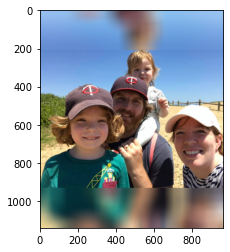

In [82]:
# test blur_padding(padded_image, padding_size)
blurred = blur_padding(padded, padding_size)
plt.imshow(blurred)

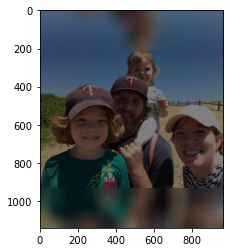

In [105]:
plt.imshow(np.floor(np.array(blurred) / 2).astype('int'))

In [104]:
np.floor(np.array(blurred) / 2).dtype

dtype('float64')

### 2.2 Trimming

In [9]:
def trim(original_image, padding_size):
    """
    Args:
    original_image -- the original image
    padding_size -- the size (height) of padding, returned by compute_padding_size()
    
    Returns:
    trimmed -- trimmed image    
    """
    
    assert(padding_size < 0)
    padding_size *= -1
    
    h, w, c = original_image.shape
    
    trimmed = original_image[:, padding_size: w-padding_size]
    
    return trimmed

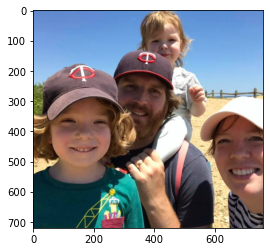

In [10]:
original_image = io.imread(r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\Kyle\kyle_family_Long Island.jpg')
padding_size = -100
trimmed = trim(original_image, padding_size)
plt.imshow(trimmed)

## 3. Save picture

Now we have the padded picture with desired aspect ratio. All that is left is to save the picture with a fixed size and dpi. 

In [83]:
def save_picture(fname, img, shape_set, dpi):
    """
    Args:
    fname -- name of the file to be saved
    img -- img to be saved
    shape_set -- the shape of output image we set
    dpi -- dots per inch of output image
    
    Returns:
    Nothing
    """
    fig = plt.figure(figsize=(shape_set[1]/dpi, shape_set[0]/dpi))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(img)
    ax.axis('off')
    fig.savefig(fname, dpi=dpi)
    return 0

0

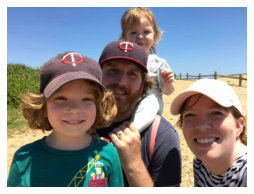

In [12]:
img = io.imread(r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\Kyle\kyle_family_Long Island.jpg')
fname = r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\processed\1.jpg'
shape_set = (1800, 1000)
dpi = 300
save_picture(fname, img, shape_set, dpi)

## 4. All in one, collage maker

Now let's put everything  together!

In [112]:
def collage_maker(img, fname, shape_set, dpi, padding_sharpness=5, dark_factor=1.2):
    """
    Args:
    original_image -- the original image
    fname -- name of the file to be saved
    shape_set -- the shape of output image we set
    dpi -- dots per inch of output image
    padding_sharpness -- how clear the padding parts are, larger value means sharper padding
    dark_factor -- darken the padding parts, 1 is original

    Returns:
    nothing
    """
    
    resized = resize_image(original_image, shape_set)
    shape_resized = (resized.shape[0], resized.shape[1])
    padding_size = compute_padding_size(shape_resized, shape_set)
    
    if padding_size >= 0:
        padded_img = np.pad(resized, ((padding_size, padding_size), (0, 0), (0, 0)), mode='reflect')
        processed_image = blur_padding(padded_img, padding_size, padding_sharpness=padding_sharpness, dark_factor=dark_factor)
    else:
        processed_image = trim(resized, padding_size)
        
    save_picture(fname, processed_image, shape_set, dpi)    
    
    return processed_image

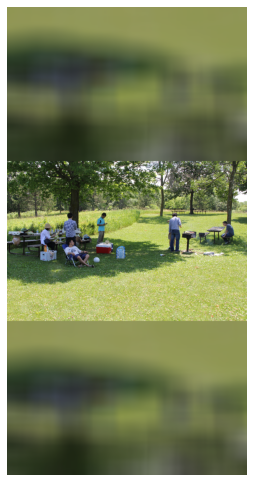

In [113]:
# test collage_maker(original_image, fname, shape_set, dpi)
original_image = io.imread(r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\Bo\2016_Statepark.jpg')
shape_set = (1950, 1000)
fname = r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\processed\1.jpg'
dpi = 300

i = collage_maker(original_image, fname, shape_set, dpi, padding_sharpness=8, dark_factor=1.3)

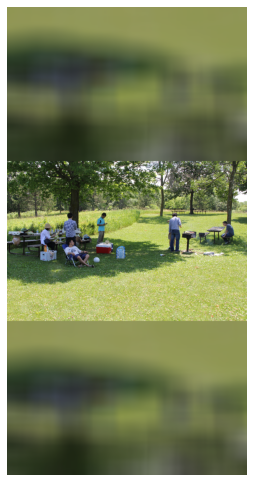

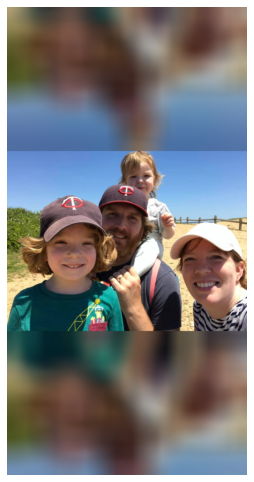

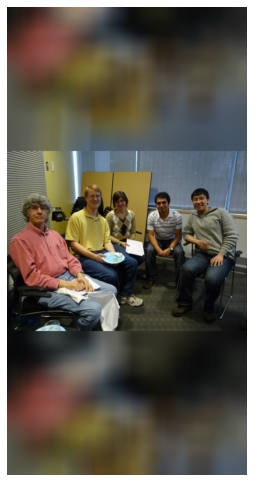

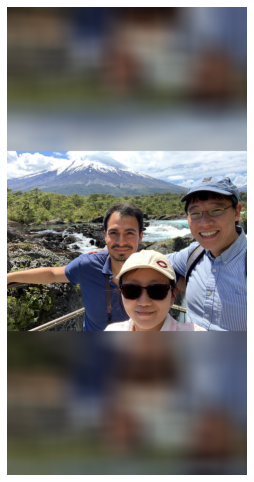

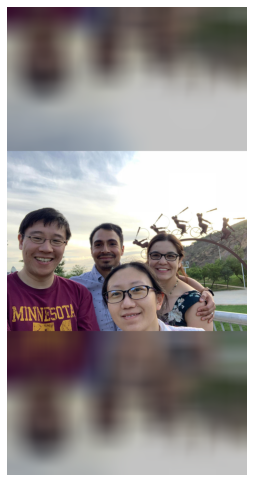

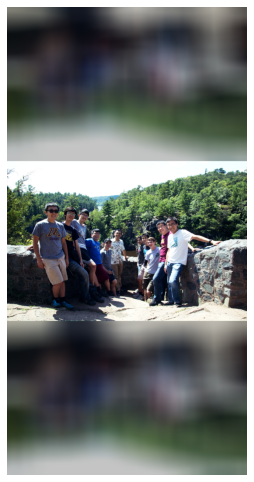

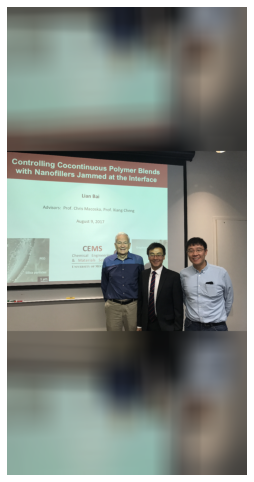

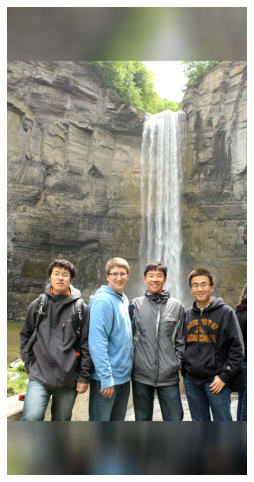

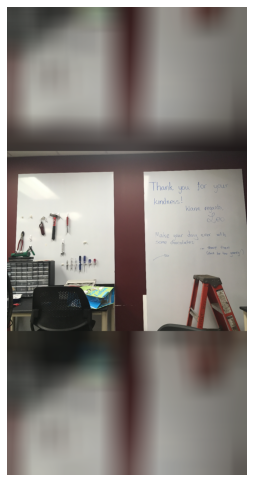

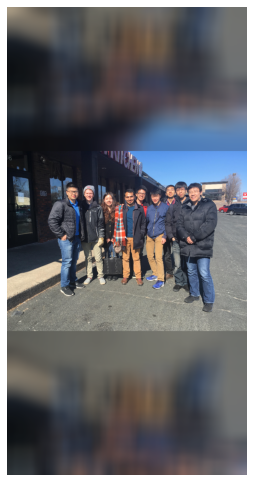

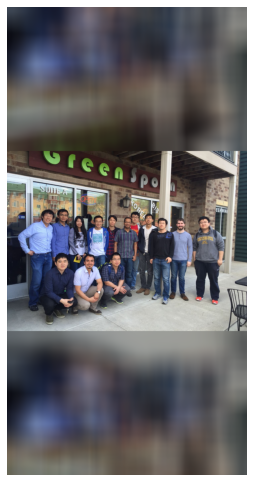

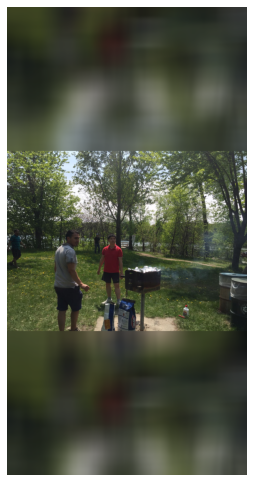

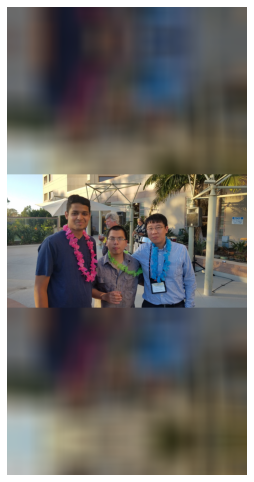

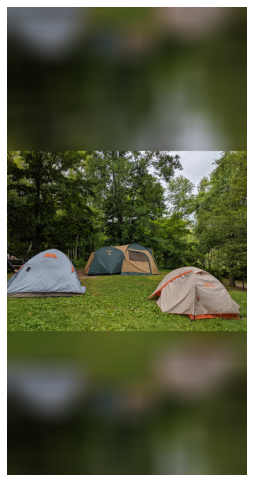

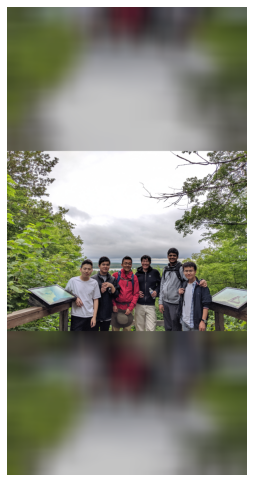

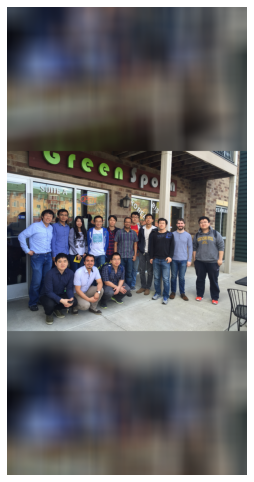

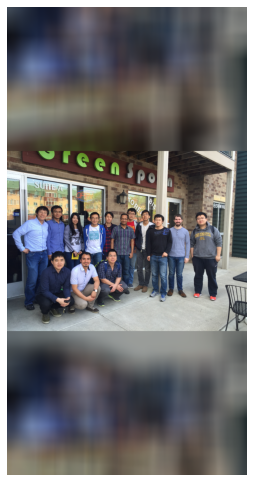

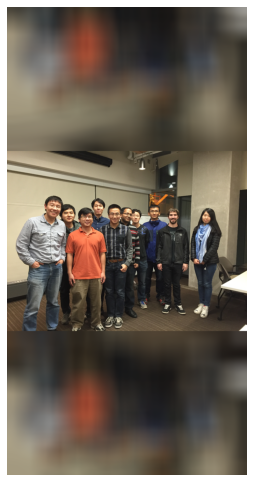

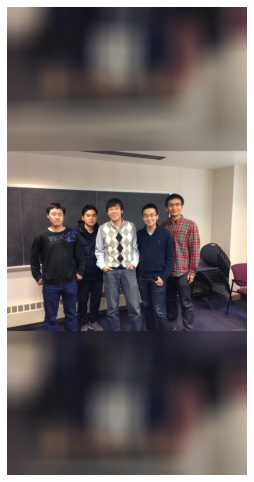

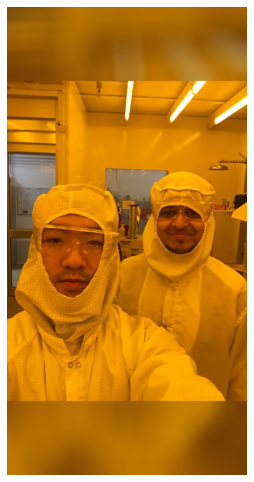

In [114]:
image_folder = r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday'
output_folder = r'E:\Google Drive\Pictures and videos\Xiang 40th Birthday\processed'
shape_set = (1950, 1000)
dpi = 300

for d in mil.dirrec(image_folder, '*'):
    if d.lower().endswith('.jpg') and d.find(output_folder) < 0:
        original_image = io.imread(d)
        f, n = os.path.split(d)
        fname = os.path.join(output_folder, n)        
        i = collage_maker(original_image, fname, shape_set, dpi, padding_sharpness=8, dark_factor=1.3)